In [69]:
import sys

sys.path.append("../src")

# Quickstart 1: Functional Variational Autoencoder (FVAE)

This notebook gives a simple introduction to get started with the **functional variational autoencoder** (FVAE).
To get started, let's set up a simple FVAE model for one-dimensional SDE data, similar to the example in section 2.5.1 of [the paper](https://arxiv.org/pdf/2408.01362). 

> ⚠ **Have you installed the dependencies for `functional_autoencoders` yet?** If not, head to the `functional_autoencoders/` directory in your terminal and run `pip install -r requirements.txt`. 


**Dataset**. We'll train FVAE with 2,048 sample paths of the stochastic differential equation (SDE)

$$ \mathrm{d} u_{t} = -\nabla U(u_{t}) \, \mathrm{d} t + \sqrt{\varepsilon} \,\mathrm{d} w_{t},\quad t \in [0, T],$$

where $(w_{t})_{t \in [0, T]}$ is Brownian motion on $\mathbb{R}$. 
This SDE is known as the **Brownian dynamics** model, representing a gradient flow to minimise a **potential energy** $U \colon \mathbb{R} \to \mathbb{R}$ perturbed by additive thermal noise of temperature $\sqrt{\varepsilon}$. 
We'll assume

$$ U(x) = 3x^{4} + 2x^{3} - 6x^{2} + 6x,$$

with $\varepsilon = 1$, $T = 5$, and $u_{0} = -1$. 
To do this, we'll use the `functional_autoencoders.datasets.SDE` class to generate the SDE sample paths. 
Although the underlying sample paths are functions, we'll work with training data discretised on 64 equally spaced timesteps, which will be generated by the `SDE` class using an Euler–Maruyama scheme.

In [70]:
import numpy as np
from functional_autoencoders.datasets import get_dataloaders
from functional_autoencoders.datasets.sde import (
    SDE,
    get_brownian_dynamics_diffusion,
    get_brownian_dynamics_drift,
)

EPSILON = 1
X0 = np.array([-1.0])
potential = lambda x: 3 * x[0] ** 4 + 2 * x[0] ** 3 - 6 * x[0] ** 2 - 6 * x[0]
drift = get_brownian_dynamics_drift(potential)
diffusion = get_brownian_dynamics_diffusion(epsilon=EPSILON)

train_dataloader, test_dataloader = get_dataloaders(
    SDE,
    drift=drift,
    diffusion=diffusion,
    x0=X0,
    T=5,
    samples=2_048,
    pts=256,
)

The `get_dataloaders` helper function can take any dataset from `functional_autoencoders.datasets` and instantiate dataloaders (based on the PyTorch dataloader, as explained in [the JAX documentation](https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html)) for the training and test datasets.

Generally, we'll use the `train_dataloader` and `test_dataloader` objects as iterators which return batches of training/test samples. 
But, for the purpose of visualization, let's access a single element from the underlying dataset by indexing `train_dataloader.dataset`.

The convention for all the datasets in `functional_autoencoders.datasets` is that each element of the dataset is a tuple `(u_enc, x_enc, u_dec, x_dec)` representing the underlying function $u \colon \Omega \subset \mathbb{R}^{d} \to \mathbb{R}^{m}$, where:

- `u_enc` and `u_dec` are JAX arrays of shape `(number_of_evaluations, m)` and `x_enc` and `x_dec` are JAX arrays of shape `(number_of_evaluations, d)`;
- `u_enc[i, :]` represents the value $u(x_{i}) \in \mathbb{R}^{m}$, where $x_{i}$ is given by the array `x_enc[i, :]` of length `d`;
- `u_dec[i, :]` similarly represents $u(x_{i}) \in \mathbb{R}^{m}$, but this time $x_{i}$ is given by `x_dec[i, :]`.

The reason for this convention is that the encoder and decoder architectures can be evaluated on **distinct** meshes of points–as we'll see in the next notebook, this convention is especially useful when using **self-supervised training**.

Text(0.5, 0, '$t$')

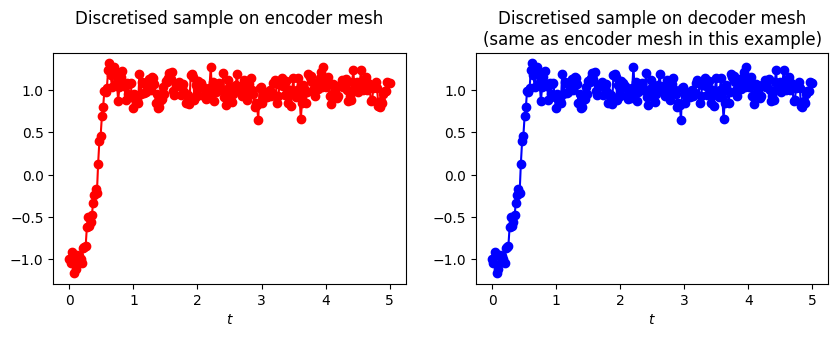

In [71]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 3)

u_enc, x_enc, u_dec, x_dec = train_dataloader.dataset[0]
plt.subplot(1, 2, 1)
plt.plot(x_enc, u_enc, "ro-")
plt.title("Discretised sample on encoder mesh\n")
plt.xlabel("$t$")

plt.subplot(1, 2, 2)
plt.plot(x_dec, u_dec, "bo-")
plt.title("Discretised sample on decoder mesh\n(same as encoder mesh in this example)")
plt.xlabel("$t$")

To follow the setup in the paper as closely as possible, we'll assume that the data are provided to us with each sample missing 50% of the time steps.
We can do this easily by slightly modifying the data loading code we just used;
let's regenerate the dataset and see how it's done.

> ⚠️ Although this will mean `x_enc[i,:]` and `x_dec[i,:]` will be equal for each `i`, bear in mind that `x_enc[i,:]` and `x_enc[j,:]` might be different–the mesh can vary for each example in the dataset.

Text(0.5, 0, '$t$')

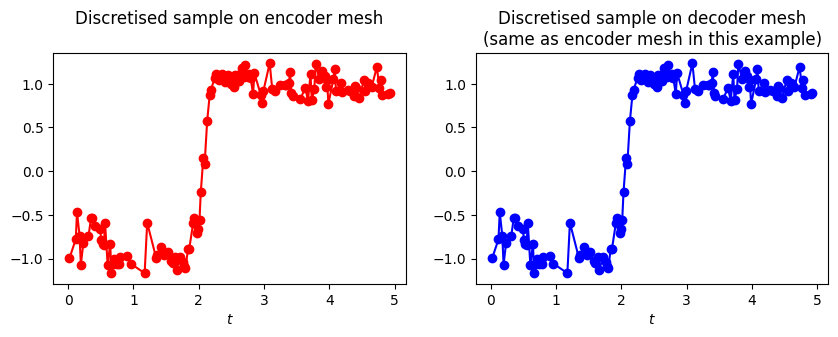

In [4]:
from functional_autoencoders.datasets import RandomMissingData

EPSILON = 1
X0 = np.array([-1.0])
potential = lambda x: 3 * x[0] ** 4 + 2 * x[0] ** 3 - 6 * x[0] ** 2 - 6 * x[0]
drift = get_brownian_dynamics_drift(potential)
diffusion = get_brownian_dynamics_diffusion(epsilon=EPSILON)

# !! The `RandomMissingData` class transforms the sample paths generated by the `SDE`
#    dataset, keeping 50% (point_ratio=0.5) of time steps from both the
#    encoder and decoder data.
missing_data = RandomMissingData(point_ratio=0.5)

train_dataloader, test_dataloader = get_dataloaders(
    SDE,
    drift=drift,
    diffusion=diffusion,
    x0=X0,
    T=5,
    samples=2_048,
    pts=256,
    transform_generated=missing_data,
)

u_enc, x_enc, u_dec, x_dec = train_dataloader.dataset[0]
plt.subplot(1, 2, 1)
plt.plot(x_enc, u_enc, "ro-")
plt.title("Discretised sample on encoder mesh\n")
plt.xlabel("$t$")

plt.subplot(1, 2, 2)
plt.plot(x_dec, u_dec, "bo-")
plt.title("Discretised sample on decoder mesh\n(same as encoder mesh in this example)")
plt.xlabel("$t$")

Now, let's learn how to set up the FVAE architecture and training objective. There is a wide selection of encoders and decoders to choose from (see [the custom architectures notebook](./4_Custom_Architectures.ipynb) for more on this), but we'll stick with the architectures described in the paper:

**`PoolingEncoder`**, which at the function-space level is given by integration of a learnable vector-valued kernel $\kappa$ followed by a learnable MLP $\rho$, i.e.,

$$\rho\left( \int_{\Omega} \kappa\bigl(x, u(x)\bigr) \,\mathrm{d} x \right),$$

and closely resembles architectures such as Deep Sets and PointNets.

![FVAE `PoolingEncoder`](./images/FVAE_encoder.png)



**NonlinearDecoder**, which is a coordinate MLP taking the latent vector $z$ and a query point $x_{k}$ and returning the value $u(x_{k})$ of the decoded function.

![FVAE `NonlinearDecoder`](./images/FVAE_decoder.png)

The most important things to choose for the encoder and decoder architectures are:

1. Whether we're training a variational autoencoder (`is_variational = True`) or not (`is_variational = False`), which determines whether the encoder outputs distributional parameters for a Gaussian variational approximation (FVAE) or just a single point (FAE).
2. The dimension `latent_dim` of the latent space $\mathcal{Z} = \mathbb{R}^{d_{\mathcal{Z}}}$ (for FVAE, this is the dimension of the encoder mean).
3. The parameter `out_dim`, which controls the dimension of the **range** of the decoded functions.

Once the encoder and decoder are set up, they can be combined to form the `Autoencoder` object.

In [5]:
from functional_autoencoders.autoencoder import Autoencoder
from functional_autoencoders.encoders.pooling_encoder import PoolingEncoder
from functional_autoencoders.decoders.nonlinear_decoder import NonlinearDecoder

encoder = PoolingEncoder(is_variational=True, latent_dim=1)
decoder = NonlinearDecoder(out_dim=1, features=(100, 100, 100, 100, 100))
autoencoder = Autoencoder(encoder=encoder, decoder=decoder)

Once the architecture is fixed, we now need to set up a loss function. We'll use the loss function specialised to SDE path distributions in `functional_autoencoders.losses.fvae_sde`, as described in the paper.


All losses in `functional_autoencoders` require that you pass a `domain` object, which encodes the underlying function space that the data lie in and the appropriate function-space norms. We'll talk more about this in the next notebook–for SDE data, we can just use the `SDE` domain which encodes the correct Cameron–Martin norms and inner products.

Once the `domain` object is set up, we just need to obtain a loss function by passing:
- the `autoencoder` architecture we just set up;
- the `domain` object;
- hyperparameters for the SDE loss, as described in [the paper](https://arxiv.org/abs/2408.01362), briefly summarised as:
    - `beta`: the scale of the KL regularisation on the latent space
    - `theta`: the restoring force $\theta$ for the Ornstein–Uhlenbeck process that we use as the noising process for FVAE
    - `zero_penalty`: the scale of the penalty applied to decoder outputs for which the initial condition disagrees with `X0`
    - `n_monte_carlo_samples`: the number of Monte Carlo samples used when drawing samples from the variational distribution in the encoder.

In [13]:
from functional_autoencoders.domains.off_grid import SDE
from functional_autoencoders.losses.fvae_sde import get_loss_fvae_sde_fn

THETA = 25

domain = SDE(epsilon=EPSILON, x0=X0)
loss_fn = get_loss_fvae_sde_fn(
    autoencoder=autoencoder,
    domain=domain,
    beta=1,
    theta=THETA,
    zero_penalty=100,
    n_monte_carlo_samples=4,
)

Now we have a resolution-invariant architecture and loss, we can get started with the training process. 
Since our architecture is built on top of [JAX](https://github.com/google/jax) and [Flax](https://flax.readthedocs.io/en/latest/), you can write your own training loop easily if you like, but we provide a simple trainer, `AutoencoderTrainer`, suitable for quick prototyping.
The `AutoencoderTrainer` uses the `Adam` optimizer from the [Optax](https://github.com/google-deepmind/optax) library, which is a good default for experimentation.

The `AutoencoderTrainer` requires the `autoencoder` and `loss_fn` objects we just set up, as well as the `train_dataloader` and `test_dataloader`. 
It supports computing validation metrics (e.g., mean-square error) on the `test_dataloader` by specifying a list of `metrics`. 

To run the trainer, just call the `fit` method and specify the training hyperparameters such as learning rate (`lr`). 
Since we're using JAX, you need to explicitly pass a pseudorandom number generator key; you can read more about this in the [JAX documentation](https://jax.readthedocs.io/en/latest/random-numbers.html).
To show off the methodology, we'll do a very short training run (<10 minutes on a consumer laptop with no dedicated GPU) for this simple dataset.

In [20]:
import jax

from functional_autoencoders.train.autoencoder_trainer import AutoencoderTrainer
from functional_autoencoders.train.metrics import MSEMetric

key = jax.random.PRNGKey(seed=42)
trainer = AutoencoderTrainer(
    autoencoder=autoencoder,
    loss_fn=loss_fn,
    metrics=[MSEMetric(autoencoder=autoencoder, domain=domain)],
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
)

key, subkey = jax.random.split(key)
results = trainer.fit(
    subkey,
    lr=1e-3,
    lr_decay_step=1_000,
    lr_decay_factor=0.98,
    max_step=1500,
    verbose="full",
)

Parameter count: 57955


epoch 0 (loss -1.298E+03): 100%|██████████| 64/64 [00:27<00:00,  2.36it/s]


epoch      0 || MSE (in L^{2}): 3.959E-01


epoch 10 (loss -1.357E+03): 100%|██████████| 64/64 [00:21<00:00,  2.93it/s]


epoch     10 || MSE (in L^{2}): 3.420E-01


To test how well FVAE trained, let's autoencode a batch from the test dataset and visualize a sample.
To do this, we can use the `autoencoder.apply` method, which takes a batch of data (`u_enc` and `x_enc`); encodes to obtain the mean vector and covariance matrix of the variational distribution for the encoder; then decodes the mean vector to obtain a reconstruction of the inputs.

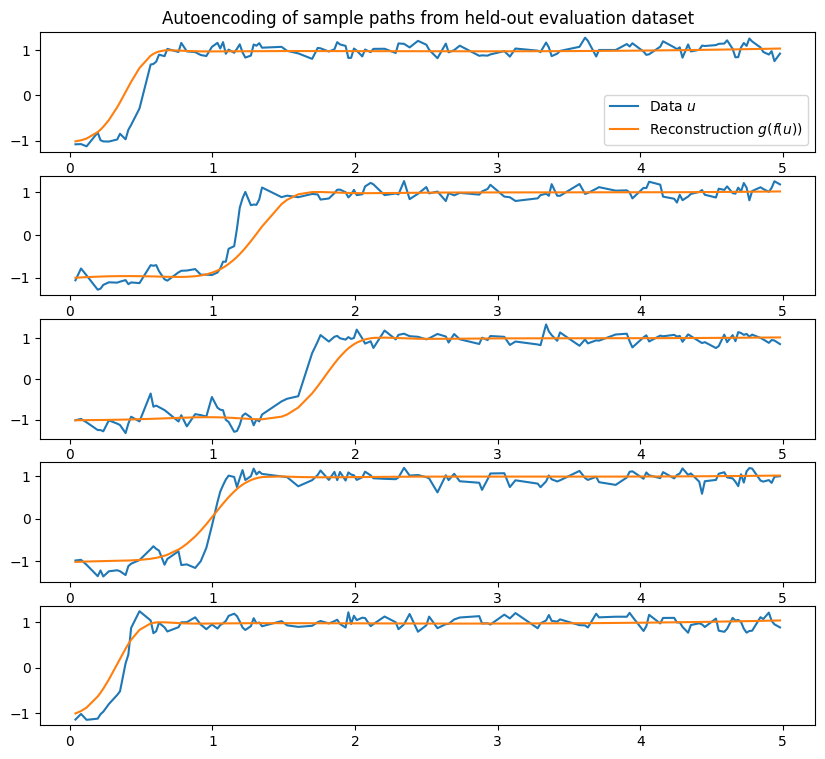

In [37]:
u_enc, x_enc, u_dec, x_dec = next(iter(test_dataloader))
state = results["state"]
u_dec = autoencoder.apply(
    {"params": state.params, "batch_stats": state.batch_stats}, u_enc, x_enc, x_dec
)

plt.rcParams["figure.figsize"] = (10, 9)
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.plot(x_enc[i, :, :], u_enc[i, :, :], label="Data $u$")
    plt.plot(x_dec[i, :, :], u_dec[i, :, :], label="Reconstruction $g(f(u))$")
    if i == 0:
        plt.legend()
        plt.title("Autoencoding of sample paths from held-out evaluation dataset")

Now, let's turn our attention to sampling from FVAE. To sample the decoder means $g(z; \theta_{g})$ from the latent $z \sim N(0, 1)$, we'll use the `SamplerVAE` class, which takes care of drawing the latents $z$ and passing them through the decoder.
A benefit of using the resolution-invariant FVAE is that the generative modelling can be done on a different mesh to the training mesh.
We'll sample on an equally spaced mesh on the time interval $[0, 5]$ with 512 mesh points, which is finer than the resolution used during training.

> ⚠️ Watch out! We're not yet sampling from the probabilistic generative model $g(z; \theta_{g}) + \eta$, with $\eta$ being the underlying reference process–`SamplerVAE` just samples the decoder means $g(z; \theta_{g})$. We'll take care of adding $\eta$ later.

Text(0.5, 1.0, '10 realizations of the decoder mean $g(z; \\theta_{g})$ with $z \\sim N(0, 1)$')

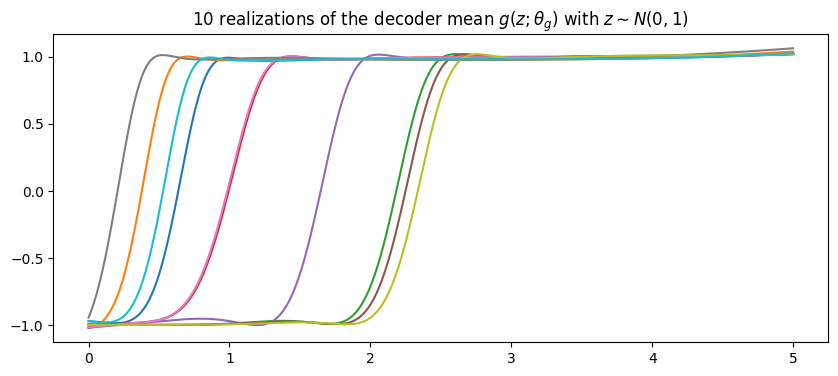

In [54]:
import jax.numpy as jnp
from functional_autoencoders.samplers.sampler_vae import SamplerVAE

plt.rcParams["figure.figsize"] = (10, 4)

N_SAMPLES = 10
MESH_POINTS_SAMPLING = 512

key, subkey = jax.random.split(key)
sampler = SamplerVAE(autoencoder, state)

x = jnp.reshape(jnp.linspace(0, 5, MESH_POINTS_SAMPLING), (1, MESH_POINTS_SAMPLING, 1))
x = jnp.repeat(x, N_SAMPLES, axis=0)
samples = sampler.sample(x, subkey)
for i in range(0, N_SAMPLES):
    plt.plot(x[i], samples[i])
plt.title(
    rf"{N_SAMPLES} realizations of the decoder mean $g(z; \theta_{{g}})$ with $z \sim N(0, 1)$"
)

To get true samples from the FVAE generative model, rather than just the decoder means, we can use the helper function `add_bm_noise`, which adds the noise term $\eta$ with specified temperature $\sqrt{\varepsilon}$ and Ornstein–Uhlenbeck restoring force $\theta$.

Text(0.5, 1.0, '10 samples from held-out dataset\n(mesh spacing 2.0e-02)')

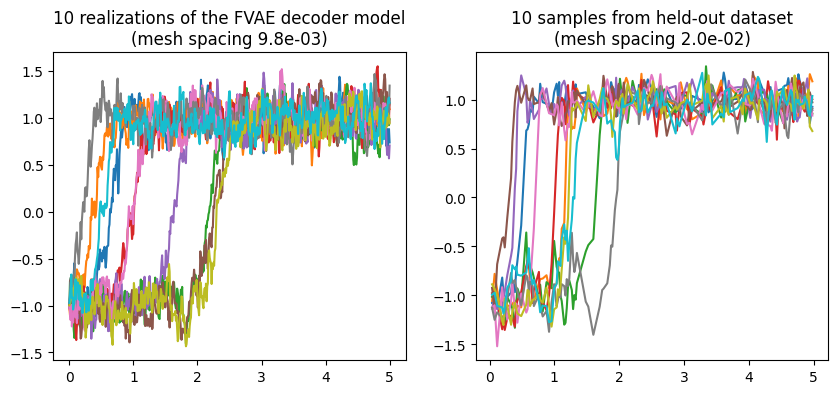

In [68]:
from functional_autoencoders.util.random.sde import add_bm_noise

sim_dt = x[0, 1, 0] - x[0, 0, 0]
samples_noised = add_bm_noise(samples, epsilon=EPSILON, theta=THETA, sim_dt=sim_dt, T=5)

plt.subplot(1, 2, 1)
for i in range(0, N_SAMPLES):
    plt.plot(x[i], samples_noised[i])
plt.title(
    f"{N_SAMPLES} realizations of the FVAE decoder model\n(mesh spacing {sim_dt:.1e})"
)
plt.subplot(1, 2, 2)
for i in range(0, N_SAMPLES):
    plt.plot(x_enc[i], u_enc[i])
plt.title(f"{N_SAMPLES} samples from held-out dataset\n(mesh spacing {5/256:.1e})")

We see very close agreement between the distributions of the FVAE samples and true samples from the held-out dataset, suggesting that FVAE has correctly characterised the statistical properties of the underlying path measure for the SDE data.

To see the exact experimental setup used in section 2.5.1 of [the paper](https://arxiv.org/abs/2308.01362), head over to the `experiments/exp_sde1d` directory.
You might also like to try varying the `THETA` parameter in this notebook and retraining to see the effect of tuning the noise process to suit the data.

## What next?
- If you haven't already, learn about the **functional autoencoder** (FAE) in [`quickstart/2_FAE.ipynb`](./2_FAE.ipynb).
- Learn how to use FVAE and FAE with your own data in [`quickstart/3_Custom_Datasets.ipynb`](./3_Custom_Datasets.ipynb).